# Look for patterns in Delta NSE

In [1]:
from pathlib import Path
import os
import warnings
from typing import Optional, List, Tuple, Dict

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [3]:
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [4]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [5]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

# assert (data_dir / f"RUNOFF/models/{EXPERIMENT}").exists()
assert (data_dir / f"RUNOFF/features/{TRUE_EXPERIMENT}").exists()

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / f'RUNOFF/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}')

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static
static_df = static.to_dataframe()

ds['station_id'] = ds['station_id'].astype(int)

In [7]:
# 13 test stations
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

# Open the Less Vars experiments (2004-2015 test)

In [8]:
print([d.name for d in (data_dir/'runs/').iterdir()])
print([d.name for d in (data_dir/'runs').glob('*_less_vars*/*E015.csv')])

['ealstm_less_vars_2004_1607_1334', 'lstm_less_vars_1307_1717', 'ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p', 'lstm_ALL_vars_2004_2210_1035', 'lstm_all_vars_1998_2008_2210_110347', 'lstm_all_vars_1998_2008_2210_110727', 'lstm_all_vars_1998_2008_nh_2310_101443']
['results_lstm_less_vars_1307_1717_E015.csv', 'results_ealstm_less_vars_2004_1707_1424_E015.csv', 'results_lstm_less_vars_2004_1507_1028_E015.csv']


In [9]:
lstm_df1 = pd.read_csv(data_dir / "runs/lstm_less_vars_2004_1507_1028/results_lstm_less_vars_2004_1507_1028_E015.csv")
lstm_df1 = pd.read_csv(data_dir / "runs/lstm_all_vars_1998_2008_nh_2310_101443/test/model_epoch030/lstm_all_vars_1998_2008_nh_2310_101443_E030.csv")
lstm_df1["time"] = pd.to_datetime(lstm_df1["time"])

In [10]:
ealstm_df = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_df["time"] = pd.to_datetime(ealstm_df["time"])

In [11]:
lstm_df2 = pd.read_csv(data_dir / "runs/lstm_ALL_vars_2004_2210_1035/results_lstm_ALL_vars_2004_2210_1035_E015.csv")
lstm_df2["time"] = pd.to_datetime(lstm_df2["time"])

In [84]:
lstm_df3 = pd.read_csv(data_dir / "runs/lstm_all_vars_1998_2008_nh_2310_101443/test/model_epoch030/lstm_all_vars_1998_2008_nh_2310_101443_E030.csv")
lstm_df3["time"] = pd.to_datetime(lstm_df3["time"])

In [12]:
# display(lstm_df1.head())
# display(lstm_df2.head())

In [85]:
lstm_preds = lstm_df3.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_df.set_index(["station_id", "time"]).to_xarray()

# Calculate Errors

In [86]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [87]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
]
ealstm_metric_df = errors[0].join(errors[1].join(errors[2])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
]
lstm_metric_df = errors[0].join(errors[1].join(errors[2])).reset_index()

# Open FUSE Models

In [88]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

### NOTE: only test performance on 1998-2008

In [91]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["target_var_original"]
).rename("discharge_spec")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)
fuse_data = fuse_data.rename({'discharge_spec': 'obs'})

# Load FUSE Errors

In [18]:
fuse_errors = pickle.load((data_dir / 'RUNOFF/FUSE_errors_recalculated.pkl').open("rb"))
fuse_errors_pub = pickle.load((data_dir / 'RUNOFF/FUSE_errors_published.pkl').open("rb"))
fuse_errors_pub = fuse_errors_pub.rename({"SACRAMENTO": "Sacramento"}, axis=1, level=1)

In [19]:
def get_error_df(model: str, fuse_errors: pd.DataFrame) -> pd.DataFrame:
    try:
        fuse_errors = fuse_errors.drop(
            [("MSE", "Name"),
            ("BIAS", "Name")],
            axis=1
        )
    except:
        pass
    
    all_models = ["TOPMODEL", "VIC", "PRMS", "Sacramento", "SACRAMENTO"]
    assert model in all_models
    
    remove_models = [m for m in all_models if m != model]
    error_df = fuse_errors.drop(remove_models, axis=1, level=1).swaplevel(axis=1).sort_index(axis=1).droplevel(axis=1, level=0)
    rename_cols = pd.io.parsers.ParserBase({'names': error_df.columns})._maybe_dedup_names(error_df.columns)
    error_df.columns = [n.lower() if (n.lower() != "nse") else "Name" for n in rename_cols]

    return error_df.rename({"nse.1": "nse"}, axis=1)


topmodel = fuse_data[["obs", "SimQ_TOPMODEL"]].to_dataframe().reset_index()
vic = fuse_data[["obs", "SimQ_ARNOVIC"]].to_dataframe().reset_index()
prms = fuse_data[["obs", "SimQ_PRMS"]].to_dataframe().reset_index()
sacramento = fuse_data[["obs", "SimQ_SACRAMENTO"]].to_dataframe().reset_index()

top_error = get_error_df("TOPMODEL", fuse_errors_pub)
vic_error = get_error_df("VIC", fuse_errors_pub)
prms_error = get_error_df("PRMS", fuse_errors_pub)
sac_error = get_error_df("Sacramento", fuse_errors_pub)

# Calculate delta NSE

In [20]:
delta_top = lstm_metric_df.set_index("station_id")["nse"] - top_error["nse"]
delta_top.name = "TOPMODEL"
delta_sac = lstm_metric_df.set_index("station_id")["nse"] - sac_error["nse"]
delta_sac.name = "Sacramento"
delta_vic = lstm_metric_df.set_index("station_id")["nse"] - vic_error["nse"]
delta_vic.name = "VIC"
delta_prms = lstm_metric_df.set_index("station_id")["nse"] - prms_error["nse"]
delta_prms.name = "PRMS"

delta_nse = pd.concat([
    delta_top,
    delta_sac,
    delta_vic,
    delta_prms,
], axis=1)

In [21]:
mean_delta = delta_nse.mean(axis=1)

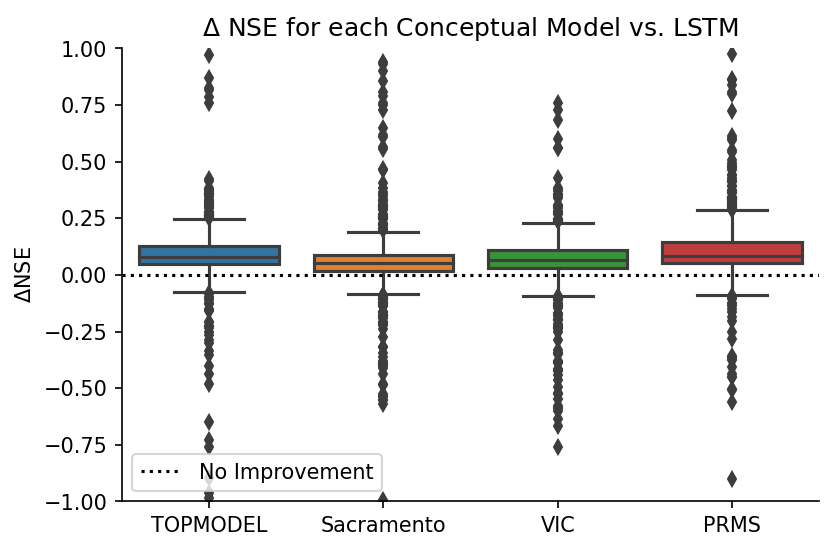

In [22]:
sns.boxplot(data=delta_nse, palette=sns.color_palette())
ax = plt.gca()
ax.set_ylim(-1, 1)
ax.axhline(0, ls=":", color="k", label="No Improvement")
ax.set_ylabel("$\Delta$NSE")
ax.legend()
ax.set_title("$\Delta$ NSE for each Conceptual Model vs. LSTM")
sns.despine()

Text(0.5, 0, '$\\Delta$NSE')

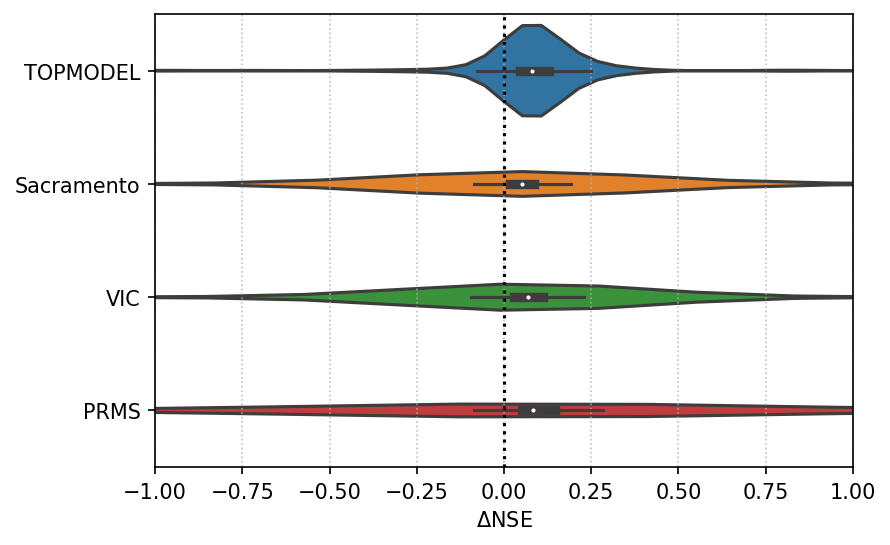

In [23]:
sns.violinplot(data=delta_nse, palette=sns.color_palette(), orient="h")
ax = plt.gca()
ax.grid(axis="x", alpha=0.8, ls=":", which="both", zorder=0)
ax.set_xlim(-1, 1)
ax.axvline(0, ls=":", color="k")
ax.set_xlabel("$\Delta$NSE")

In [24]:
# Calculate the Percentages above 0 (LSTM > Hydro)
display((delta_nse > 0).sum(axis=0) / delta_nse.count())
print()
# Calculate the Percentages belo 0 (LSTM < Hydro)
display((delta_nse < 0).sum(axis=0) / delta_nse.count())

TOPMODEL      0.877389
Sacramento    0.800955
VIC           0.839172
PRMS          0.898089
dtype: float64

TOPMODEL      0.122611
Sacramento    0.199045
VIC           0.160828
PRMS          0.101911
dtype: float64

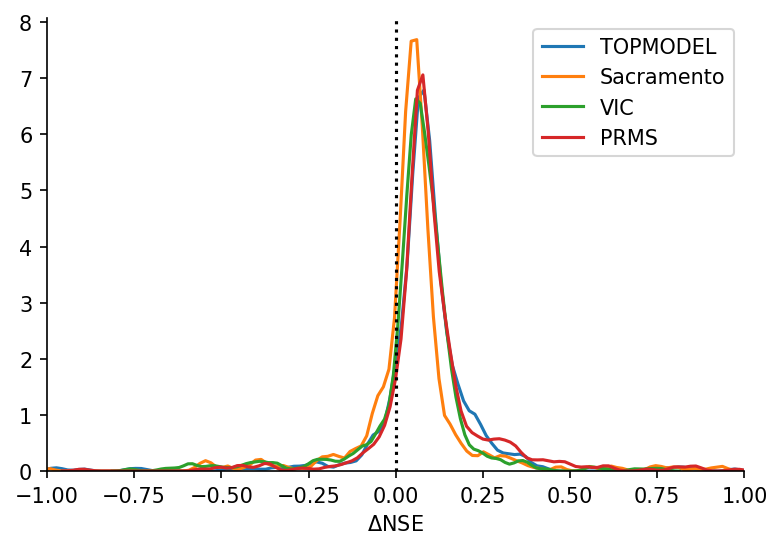

In [25]:
kde_kws = {"clip": (-1, 1)}
hist_kws = {"range": (-1, 1), "density": True}

f, ax = plt.subplots()
[
    sns.distplot(delta_nse[c], ax=ax, kde_kws=kde_kws, hist_kws=hist_kws, hist=False, label=c) 
    for c in delta_nse.columns
]
ax.set_xlim((-1, 1))
ax.axvline(0, ls=":", color="k")
ax.set_xlabel("$\Delta$NSE")
ax.legend()
sns.despine()

# What characteristics where we do better / worse

In [26]:
# Worse?
worse_cments_top = static_df[(delta_nse < 0)["TOPMODEL"]]
worse_cments_sac = static_df[(delta_nse < 0)["Sacramento"]]
worse_cments_vic = static_df[(delta_nse < 0)["VIC"]]
worse_cments_prms = static_df[(delta_nse < 0)["PRMS"]]

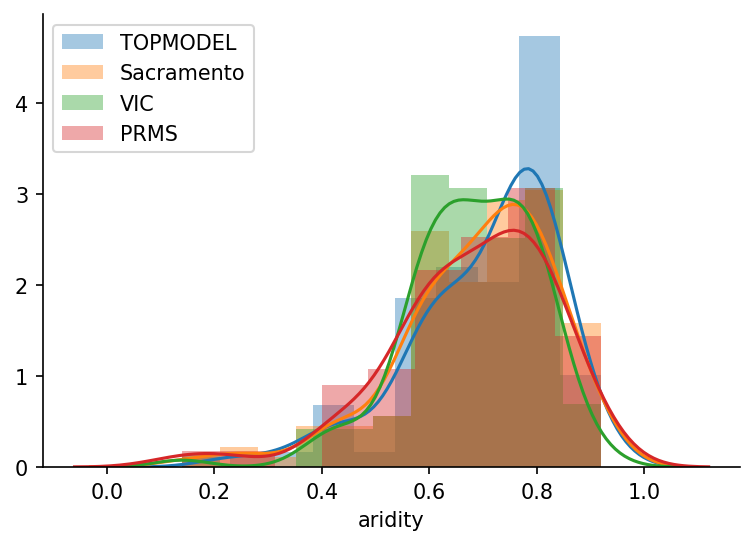

In [27]:
sns.distplot(worse_cments_top["aridity"], label="TOPMODEL")
sns.distplot(worse_cments_sac["aridity"], label="Sacramento")
sns.distplot(worse_cments_vic["aridity"], label="VIC")
sns.distplot(worse_cments_prms["aridity"], label="PRMS")
plt.legend()
sns.despine()

# Spatial Plots

In [31]:
import geopandas as gpd

shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

In [42]:
delta_df = delta_nse.reset_index()
# display(delta_df.head())

# create spatial dataframe
assert delta_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
delta_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(delta_df.set_index('station_id'))
)
delta_gdf.head()

,ID,SOURCE,VERSION,EXPORTED,geometry,TOPMODEL,Sacramento,VIC,PRMS
ID_STRING,,,,,,,,,
10002,10002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((410125.000 848525.000, 410075.000 84...",0.183610,0.105036,0.099921,0.131231
10003,10003.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((394725.000 830350.000, 394725.000 83...",0.248521,0.106554,0.068362,0.111790
1001,1001.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((326225.000 954900.000, 326225.000 95...",0.063099,0.012888,0.054221,0.030244
101002,101002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((450375.000 88125.000, 450375.000 880...",0.110307,0.001889,0.029823,0.172417
101005,101005.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((453125.000 83525.000, 453125.000 835...",0.172116,0.104417,0.139330,0.365602


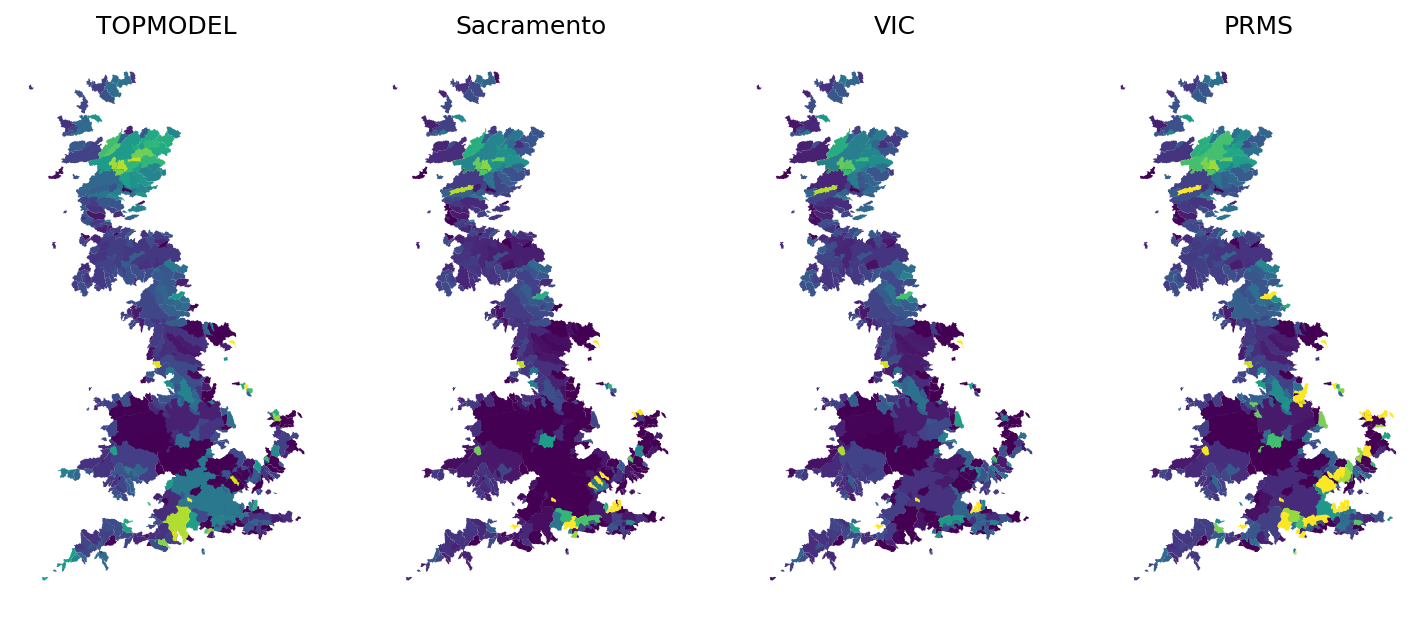

In [80]:
kwargs = {"vmin": 0, "vmax": 0.4}
f, axs = plt.subplots(1, 4, figsize=(12, 8*4))
models = ["TOPMODEL", "Sacramento", "VIC", "PRMS"]
for model, ax in zip(models, axs):
    delta_gdf.plot(model, ax=ax, **kwargs)
    ax.set_title(f"{model}")

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(axs[3])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# delta_gdf.plot("PRMS", ax=axs[3], legend=True, cax=cax, **kwargs)

for ax in axs:
    ax.axis('off')

In [83]:
delta_nse.mean(axis=0)

TOPMODEL      0.083968
Sacramento    0.144317
VIC           0.126266
PRMS          0.353386
dtype: float64

# Train RandomForests on the model performances // Delta NSE
- [sklearn implementation](https://github.com/scikit-learn/scikit-learn/pull/13146)
- [post here](https://explained.ai/rf-importance/)
- [rfpimp package](https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py#L263)

### How this works
- $y$ = delta_NSE
- $X$ = static features

In [28]:
from rfpimp import (
    importances, 
    plot_importances, 
    plot_corr_heatmap, 
    feature_corr_matrix, 
    feature_dependence_matrix,
    plot_dependence_heatmap
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [29]:
grouped_features = [
    #  HydroGeology
    ["inter_high_perc", "inter_mod_perc", "inter_low_perc",],
    ["frac_high_perc", "frac_mod_perc", "frac_low_perc",],
    ["low_nsig_perc", "nsig_low_perc",],
    "no_gw_perc",
    # Topography
    ["gauge_lat", "gauge_lon",],
    [
        "gauge_elev",
        "elev_mean",
        "elev_min",
        "elev_10",
        "elev_50",
        "elev_90",
        "elev_max",
    ],
    "dpsbar",
    #  Soil Properties
    ["sand_perc", "silt_perc", "clay_perc", "organic_perc",],
    ["bulkdens", "bulkdens_5", "bulkdens_50", "bulkdens_95",],
    [
        "tawc", "tawc_5", "tawc_50", "tawc_95"
    ],
    [
        "porosity_cosby",
        "porosity_cosby_5",
        "porosity_cosby_50",
        "porosity_cosby_95",
        "porosity_hypres",
        "porosity_hypres_5",
        "porosity_hypres_50",
        "porosity_hypres_95",
    ],
    [
        "conductivity_cosby",
        "conductivity_cosby_5",
        "conductivity_cosby_50",
        "conductivity_cosby_95",
        "conductivity_hypres",
        "conductivity_hypres_5",
        "conductivity_hypres_50",
        "conductivity_hypres_95",
    ],
    ["root_depth", "root_depth_5", "root_depth_50", "root_depth_95",],
    [
        "soil_depth_pelletier",
        "soil_depth_pelletier_5",
        "soil_depth_pelletier_50",
        "soil_depth_pelletier_95",
    ],
    #  Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    ["baseflow_index", "baseflow_index_ceh",],
    "hfd_mean",
    "Q5",
    "Q95",
    ["high_q_freq", "low_q_freq", "zero_q_freq",],
    ["high_q_dur", "low_q_dur",],
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "p_seasonality",
    "frac_snow",
    "high_prec_freq",
    "high_prec_dur",
    "low_prec_freq",
    "low_prec_dur",
    #  landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
    "inwater_perc",
    "bares_perc",
    # human influence
    "surfacewater_abs",
    "groundwater_abs",
    "discharges",
]

In [30]:
from typing import Union

def flatten(list_of_lists: List[Union[str, List]]):
    flattened = []
    for item in list_of_lists:
        if type(item) == list:
            flattened.extend([i for i in item])
        else:
            flattened.append(item)
        
    return flattened

cont_features = flatten(groups_of_colinear_features)

NameError: name 'groups_of_colinear_features' is not defined

In [ ]:
categorical_features = [
    "dom_land_cover",
    "high_prec_timing",
    "low_prec_timing",
]
numerical_features = [
    "reservoir_cap"
]
numerical_features.extend(cont_features)

important_features = [
    # topography
    "gauge_lat", 
    "gauge_lon",
    "gauge_elev",
    "dpsbar",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]

In [ ]:
# get train pairs
Ys = delta_nse.dropna()

X = static_df.loc[:, numerical_features + categorical_features]
X = X.loc[Ys.index, important_features]

assert len(X) == len(Ys)
display(Ys.head())

In [ ]:
# Processing and fitting pipeline
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
#     ('normalizer', ),
#     ('dimensional_reduction', PCA(n_components=4))
])

preprocessing = ColumnTransformer(
    [
        ('cat', categorical_pipe, categorical_features),
        ('num', numerical_pipe, numerical_features)
    ]
)

preprocessing = ColumnTransformer(
    [
        ("num", numerical_pipe, important_features)
    ]
)

rf = Pipeline([
    ('preprocess', preprocessing),
    ('Regressor', RandomForestRegressor(random_state=1, max_features=0.1, oob_score=True))
])

In [ ]:
# categorical_pipe.fit_transform(X[categorical_features])

In [ ]:
rf.fit(X, Ys);

In [ ]:
importances(rf, X, Ys)

In [ ]:
print("RF train accuracy: %0.3f" % rf.score(X, Ys))

In [ ]:
result = permutation_importance(rf, X, Ys, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [ ]:
def scatter_plot_feature(feature: str):
    f, ax = plt.subplots()
    d = delta_nse.join(static_df[feature])

    ax.scatter(d[feature], d["TOPMODEL"], marker="x", label="TOPMODEL", alpha=0.5, color=sns.color_palette()[0])
    ax.scatter(d[feature], d["Sacramento"], marker="x", label="Sacramento", alpha=0.5, color=sns.color_palette()[1])
    ax.scatter(d[feature], d["VIC"], marker="x", label="VIC", alpha=0.5, color=sns.color_palette()[2])
    ax.scatter(d[feature], d["PRMS"], marker="x", label="PRMS", alpha=0.5, color=sns.color_palette()[3])
    
    # plot linear regressions
    # m, b = np.polyfit(d[feature], d["TOPMODEL"], 1)

    ax.set_ylim(-1, 1)
    ax.set_ylabel("$\Delta$NSE")
    ax.set_xlabel(feature)
    plt.legend()
    sns.despine()
    

scatter_plot_feature("crop_perc")